In [1]:
import os
import sys
# sys.path.append("/Users/shashanks./Downloads/Installations/ddn/")
sys.path.append("./ddn/")
sys.path.append("./")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
from bernstein import bernstein_coeff_order10_new
from ddn.pytorch.node import AbstractDeclarativeNode

from utils.nodes.OPTNode_waypoint import OPTNode
from utils.dataloader import ArgoverseDataset

from utils.models.ddn import *

from utils.bernstein import bernstein_coeff_order10_new
from utils.viz_helpers import plot_traj
from utils.metrics import get_ade, get_fde

import pytorch_lightning as pl
device = 'cpu'

nvar = 11
num = 30
t_obs = 20
num_elems = 15
include_centerline = False
name = "final_without" if include_centerline else "final_with"
lr = 0.0001
shuffle = False

train_dir = "/datasets/argoverse/val_data.npy"
centerline_train_dir="/datasets/argoverse/val_centerlines.npy"
test_dir = "/datasets/argoverse/val_test_data.npy"
centerline_test_dir="/datasets/argoverse/val_test_centerlines.npy"
val_offsets_dir = "/datasets/argoverse/val_offsets.npy"

(1000, 50, 2)
AB


In [2]:
train_dataset = ArgoverseDataset(train_dir, centerline_dir=centerline_train_dir, t_obs=t_obs, dt=0.3, include_centerline = include_centerline)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=shuffle, num_workers=0)

test_dataset = ArgoverseDataset(test_dir, centerline_dir=centerline_test_dir, t_obs=t_obs, dt=0.3, include_centerline = include_centerline)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=shuffle, num_workers=0)

offsets_train = np.load(val_offsets_dir)
# offsets_test = np.load("/datasets/argoverse/val_offsets_test.npy")

problem = OPTNode(rho_eq=10, t_fin=9.0, num=num, bernstein_coeff_order10_new=bernstein_coeff_order10_new, device = device)
opt_layer = DeclarativeLayer(problem)

model = TrajNetLSTM(opt_layer, problem.P, problem.Pdot)#, input_size=t_obs * 2 + include_centerline * num_elems * 2)
# model = TrajNet(opt_layer, problem.P, problem.Pdot)#, input_size=t_obs * 2 + include_centerline * num_elems * 2)
# model = TrajNet(opt_layer, problem.P, problem.Pdot, input_size=t_obs * 2 + include_centerline * num_elems * 2)
model = model.double()
model = model.to(device)

# model.load_state_dict(torch.load("./checkpoints/final.ckpt"))

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

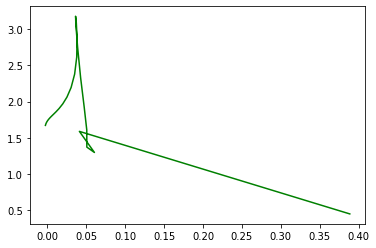

In [3]:
import pandas as pd
preds = pd.read_pickle('./file_val.pkl')
# preds
ind = 10
train_data = np.load(train_dir)
# plt.scatter(train_data[0,:, 0] + offsets_train[0,0], train_data[0, : ,1] + offsets_train[0,1])
# print(preds[li[ind]][0])
li = list(preds.keys())
plt.plot(np.array(preds[li[ind]][0])[:, 0], np.array(preds[li[ind]][0])[: ,1], color='green')
# li[0]
# preds[li[0]]

torch.Size([20, 20, 2]) torch.Size([20, 60])
torch.Size([20])
torch.Size([20, 1])


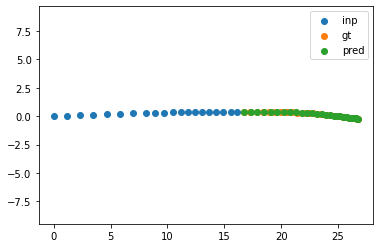

In [4]:
for batch_num, data in enumerate(train_loader):
    traj_inp, traj_out, fixed_params, var_inp = data
#     variable_params = 
    torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, profile=None, sci_mode=False)
    print(traj_inp.size(), traj_out.size())
    ade = []
    fde = []
    
    x_gt = traj_out[:,29]
    y_gt = traj_out[:,59]
    x_gt = x_gt.reshape(x_gt.shape[0], 1)
    y_gt = y_gt.reshape(x_gt.shape[0], 1)
    psi_last = var_inp[:, 2].reshape(20, 1)
    print(traj_out[:, 10].shape)
    print(y_gt.shape)
    x_mid_1 = traj_out[:, 10].reshape(traj_out[:, 10].shape[0], 1)
    x_mid_2 = traj_out[:, 20].reshape(traj_out[:, 20].shape[0], 1)
    y_mid_1 = traj_out[:, 40].reshape(traj_out[:, 40].shape[0], 1)
    y_mid_2 = traj_out[:, 50].reshape(traj_out[:, 50].shape[0], 1)
    variable_params = torch.cat((x_gt, y_gt,psi_last, x_mid_1, y_mid_1, x_mid_2, y_mid_2), axis=1)
    sol = opt_layer(fixed_params, variable_params)

    # Compute final trajectory    
    x_pred = torch.matmul(problem.P, sol[:, :nvar].transpose(0, 1))
    y_pred = torch.matmul(problem.P, sol[:, nvar:2*nvar].transpose(0, 1))
    x_pred = x_pred.transpose(0, 1)
    y_pred = y_pred.transpose(0, 1)

    out = torch.cat([x_pred, y_pred], dim=1)
    plt.scatter(traj_inp[1,:, 0], traj_inp[1, :, 1], label='inp')
#     plt.scatter(traj_out[1,:, 0], traj_out[1, :, 1], label='gt')
#     plt.scatter(out[1,:, 0].detach(), out[1, :, 1].detach(), label='pred')
    plt.scatter(traj_out[1][:30], traj_out[1][30:], label='gt')
    plt.scatter(out[1][:30].detach(), out[1][30:].detach(), label='pred')
    if include_centerline:
        inp_len=t_obs * 2
        c_len = t_obs * 2 + num_elems * 2
        plt.plot(traj_inp[1][inp_len:c_len:2] , traj_inp[1][inp_len + 1:c_len:2], color='black',label='primary-centerline')
    plt.axis('equal')
    plt.legend()
    break

Epoch: 0, Batch: 0, Loss: 0.6688172807503356
ADE: 0.7880662705859578 FDE: 2.1473532195914405e-06
Epoch: 0, Batch: 10, Loss: 0.5724775015080912
ADE: 0.7676079396497932 FDE: 9.337526001410286e-06
Epoch: 0, Batch: 20, Loss: 0.42707250056545
ADE: 0.6493092147125659 FDE: 0.0003055661553425805
Epoch: 0, Batch: 30, Loss: 0.49584420824838477
ADE: 0.7379146714170328 FDE: 0.000439092181440531
Epoch: 0, Batch: 40, Loss: 0.3475825966245857
ADE: 0.5975145482951175 FDE: 0.0016353745528195833
Epoch: 0, Mean Loss: 0.45008451542542216
Mean ADE: 0.6852450277550238 Mean FDE: 0.0002843873281455634
----------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

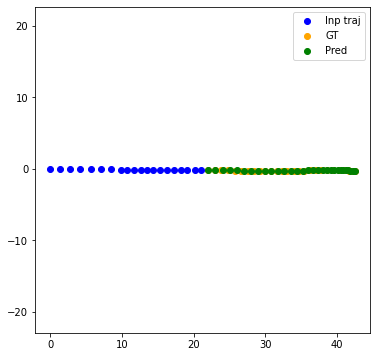

In [7]:
epoch_train_loss = []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss = []
    mean_ade = []
    mean_fde = []    
    for batch_num, data in enumerate(train_loader):
        traj_inp, traj_out, fixed_params, var_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        fixed_params = fixed_params.to(device)
        var_inp = var_inp.to(device)

        ade = []
        fde = []            
        x_gt = traj_out[:,29]
        y_gt = traj_out[:,59]
        x_gt = x_gt.reshape(x_gt.shape[0], 1)
        y_gt = y_gt.reshape(x_gt.shape[0], 1)
        psi_last = var_inp[:, 2].reshape(20, 1)
        
        x_mid_1 = traj_out[:, 10].reshape(traj_out[:, 10].shape[0], 1)
        x_mid_2 = traj_out[:, 20].reshape(traj_out[:, 20].shape[0], 1)
        y_mid_1 = traj_out[:, 40].reshape(traj_out[:, 40].shape[0], 1)
        y_mid_2 = traj_out[:, 50].reshape(traj_out[:, 50].shape[0], 1)
        variable_params = torch.cat((x_gt, y_gt,psi_last, x_mid_1, y_mid_1, x_mid_2, y_mid_2), axis=1)
        
        
#         variable_params = torch.cat((x_gt, y_gt,psi_last), axis=1)
        sol = opt_layer(fixed_params, variable_params)

        # Compute final trajectory    
        x_pred = torch.matmul(problem.P, sol[:, :nvar].transpose(0, 1))
        y_pred = torch.matmul(problem.P, sol[:, nvar:2*nvar].transpose(0, 1))
        x_pred = x_pred.transpose(0, 1)
        y_pred = y_pred.transpose(0, 1)

        out = torch.cat([x_pred, y_pred], dim=1)
        loss = criterion(out, traj_out)

        train_loss.append(loss.item())
        for ii in range(traj_inp.size()[0]):
            gt = [[out[ii][j].item(),out[ii][j + num].item()] for j in range(len(out[ii])//2)]
            pred = [[traj_out[ii][j].item(),traj_out[ii][j + num].item()] for j in range(len(out[ii])//2)]
            ade.append(get_ade(np.array(pred), np.array(gt)))
            fde.append(get_fde(np.array(pred), np.array(gt)))                                    
            plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = [], avm=None, center=include_centerline, inp_len=t_obs * 2, c_len = t_obs * 2 + num_elems * 2, num=num, mode="test", batch_num=batch_num)            #             plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = [], avm=None, center=include_centerline, inp_len=t_obs * 2, c_len = t_obs * 2 + num_elems * 2, num=num, mode="test", batch_num=batch_num)
        if batch_num % 10 == 0:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch, batch_num, loss.item()))
            print("ADE: {}".format(np.mean(ade)), "FDE: {}".format(np.mean(fde)))

        mean_ade.append(np.mean(ade))
        mean_fde.append(np.mean(fde))

    mean_loss = np.mean(train_loss)
    epoch_train_loss.append(mean_loss)
    torch.save(model.state_dict(), "./checkpoints/{}.ckpt".format(name))
    print("Epoch: {}, Mean Loss: {}".format(epoch, mean_loss))
    print("Mean ADE: {}".format(np.mean(mean_ade)), "Mean FDE: {}".format(np.mean(mean_fde)))
    print("-"*100)

In [ ]:
with torch.no_grad():
    cnt = 0
    test_loss = []
    mean_ade = []
    mean_fde = []     
    for batch_num, data in enumerate(test_loader):
        traj_inp, traj_out, fixed_params, var_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        fixed_params = fixed_params.to(device)
        var_inp = var_inp.to(device)
        
        ade = []
        fde = []        
        
        out = model(traj_inp, fixed_params, var_inp)
        loss = criterion(out, traj_out)
        
        test_loss.append(loss.item())
        print("Batch: {}, Loss: {}".format(batch_num, loss.item()))
        
        for ii in range(traj_inp.size()[0]):
            gt = [[out[ii][j],out[ii][j + num]] for j in range(len(out[ii])//2)]
            pred = [[traj_out[ii][j],traj_out[ii][j + num]] for j in range(len(out[ii])//2)]
            ade.append(get_ade(np.array(pred), np.array(gt)))
            fde.append(get_fde(np.array(pred), np.array(gt)))                        
            plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = [], avm=None, center=include_centerline, inp_len=num * 2, c_len = num * 2 + num_elems * 2, num=num, mode="test", batch_num=batch_num)

        mean_ade.append(np.mean(ade))
        mean_fde.append(np.mean(fde))  

mean_loss = np.mean(test_loss)
print("Epoch Mean Test Loss: {}".format(mean_loss))
print("Mean ADE: {}".format(np.mean(mean_ade)), "Mean FDE: {}".format(np.mean(mean_fde)))